# Tutorial 4a: Parameter estimation by optimization

(c) 2017 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t4a_parameter_estimation_by_optimization.ipynb).*

Loading BokehJS ...


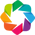

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import bebi103

import bokeh.plotting
import bokeh.io
bokeh.io.output_notebook()

import holoviews as hv
hv.extension('bokeh')

# Holoviews preferences
%opts Scatter [show_grid=True, height=300, width=450] (color='#1f77b4', alpha=0.25)
%opts Curve (color='#ff7f0e')

In this tutorial, we will extend our introduction to parameter estimation from lecture toward computing regressions on data.  We will use the data set from [Good, et al., 
 *Science*, **342**, 856-860, 2013](https://doi.org/10.1126/science.1243147) from [lecture 3](../lecture_notes/l03_constructing_models.pdf). If you missed lecture, you should read the notes to catch yourself up on the experiment.

## Exploratory data analysis

As we have been emphasizing, it is always good to explore your data set before jumping right into statistical inference. Let's start by loading in the data set, which you can download [here](../data/good_invitro_droplet_data.csv).

In [2]:
# Load in Data Frame
df = pd.read_csv('../data/good_invitro_droplet_data.csv', comment='#')

# Take a look
df.head()

Droplet Diameter (um)  Droplet Volume (uL)  Spindle Length (um)  \
0                   27.1             0.000010                 28.9   
1                   28.2             0.000012                 22.7   
2                   29.4             0.000013                 26.2   
3                   31.0             0.000016                 19.2   
4                   31.0             0.000016                 28.4   

   Spindle Width (um)  Spindle Area (um2)  
0                10.8               155.8  
1                 7.2                81.5  
2                10.5               138.3  
3                 9.4                90.5  
4                12.1               172.4

Ah, a nice, tidy data set. We can unleash HoloViews on it right away to make a plot.

In [3]:
# Use extents kwarg to show origin.
scatter = hv.Scatter(df,
                     kdims=['Droplet Diameter (um)'],
                     vdims=['Spindle Length (um)'],
                     extents=(0, 0, None, None))

scatter = bebi103.viz.adjust_range(scatter)

scatter

:Scatter   [Droplet Diameter (um)]   (Spindle Length (um))

Our objective is to use these data to obtain parameter estimates under two different models for spindle size. Remember, by "parameter estimation," we mean that we wish to compute a posterior distribution for the parameter set $\theta$, given the data. That is, we want to compute $g(\theta \mid \mathbf{d}, \mathbf{l})$, where $\mathbf{d}$ and $\mathbf{l}$ are respectively the set of droplet diameters and spindle lengths. Beyond computing the posterior, we with to obtain summaries of it. Specifically, we want to obtain most probable parameter values with error bars.

### Models for spindle size

The parameter sets are defined by one of two models for spindle size. The first model, which we shall call the independent size model, posits that spindle size is independent of droplet size.  In this model

\begin{align}
l = l_s,
\end{align}

where $l$ is the measured length of the spindle and $l_s$ is the fixed spindle size.

We will call the second model the tubulin conservation model, the mathematical expression for which we derived in lecture 3.

\begin{align}
l(d;\gamma, \phi) = \frac{\gamma d}{(1 + (d/\phi)^3)^\frac{1}{3}},
\end{align}

where $d$ is the droplet diameter.

### Checking model assumptions
When we derived the tubulin conservation model (again, see the lecture notes), we made two key assumptions.
1. The volume of the droplet is much larger than that of the spindle, or $V_0 \gg V_s$.
2. The aspect ratio of the spindles, $k$, is the same for all spindles.

As part of exploratory data analysis, we should check to see if these assumptions are indeed born out in the data. First, we will plot the ECDF of $V_s/V_0$, the ratio of the spindle volume to that of the droplet. We should have $V_s/V_0 \ll 1$. We model the spindle as a prolate spheroid. Recall that a prolate spheroid of length $l$ and width $w$ is $V_s = \pi l w^2 / 6$.  Also remember that 1 µL = $10^{-9}$ µm$^3$.

In [4]:
# Compute spindle volume
spindle_volume = np.pi * df['Spindle Length (um)'] \
                        * df['Spindle Width (um)']**2 / 6.0 * 1e-9

# Compute the ratio V_s / V_0
vol_ratio = spindle_volume / df['Droplet Volume (uL)']

# Plot ECDF
p = bebi103.viz.ecdf(vol_ratio, x_axis_label='Vs/V0')
bokeh.io.show(p)

We see that for the vast majority of spindles that were measured, $V_\mathrm{s} / V_0$ is small.

Now we ask, do all spindles have the same aspect ratio $k$? We can check this assumption because we have the data to do so available to us.

In [5]:
# Compute the aspect ratio
k = df['Spindle Width (um)'] / df['Spindle Length (um)']

# Plot ECDF
p = bebi103.viz.ecdf(k, x_axis_label='k (spindle aspect ratio)')
bokeh.io.show(p)

The mean aspect ratio is about 0.4, and we see spindle lengths about $\pm 25\%$ of that.  This could be significant variation, but we will leave it to the homework to test that.  For the purposes of this tutorial, we will assume that $k$ is constant.

## Statistical model for the independent size model

The independent size model suggests that all spindles are the same size. Of course, there will be some variability about this small size. We denote by $e_i$ the difference between the spindle of measurment $i$ and $l_s$, i.e., $l_i = l_s + e_i$. We might model that variability as Gaussian and assume homoscedasticity, with $e_i \sim \text{Norm}(0, \sigma)$, or

\begin{align}
f(e_i\mid \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\,\mathrm{e}^{-e_i/2\sigma^2}.
\end{align}

Then, our likelihood for the spindle lengths is

\begin{align}
l_i \mid l_s, \sigma \sim \text{Norm}(l_s, \sigma) \;\forall i,
\end{align}

or

\begin{align}
f(\mathbf{l}\mid l_s, \sigma) = \left(\frac{1}{2\pi\sigma^2}\right)^{\frac{n}{2}}\,\exp\left[-\frac{1}{2\sigma^2}\sum_i (l_i-l_s)^2\right].
\end{align}

We will use a Jeffreys prior for $\sigma$, and a Uniform prior for $l_s$, giving a prior of

\begin{align}
g(l_s, \sigma) = g(l_s) g(\sigma) = \frac{1}{(l_{s,\mathrm{max}} - l_{s,\mathrm{min}}) \ln(\sigma_\mathrm{max} / \sigma_\mathrm{min})\,\sigma}.
\end{align}

With the likihood and prior specified, we have out complete statistical model. We can directly write the posterior to within a multiplicative normalization constant (the evidence).

\begin{align}
g(l_s, \sigma\mid \mathbf{l}) \propto \frac{1}{\sigma^{n+1}}\, \exp\left[-\frac{1}{2\sigma^2}\sum_i (l_i-l_s)^2\right],
\end{align}

where we have lumped all terms not involving the parameters $l_s$ and $\sigma$ into a constant of proportionality. Note that if we wish, we can take $l_{s,\mathrm{min}}, \sigma_\mathrm{min} = 0$ and $l_{s,\mathrm{max}}, \sigma_\mathrm{max} \to\infty$ because the integral of the right hand side of the above equation on the interval $l_s,\sigma \in [0,\infty)$ is finite, so the posterior is normalization. This means that we can use improper priors for this parameter estimation problem.

### Plotting the posterior

We can directly plot the posterior. It helps to simplify the expression of the posterior in terms of the sample mean $\bar{l}$ and sample variance $r^2$ of the spindle lengths as in lecture 2.

\begin{align}
g(l_s, \sigma\mid \bar{l}, r^2) \propto \frac{1}{\sigma^{n+1}}\, \exp\left[-\frac{n((\bar{l}-l_s)^2 + r^2)}{2\sigma^2}\right]
\end{align}

First, we'll code up the log posterior.

In [6]:
def log_like_indep_size(l_s, sigma, l_bar, r2, n):
    """
    Compute the unnormalized log likelihood for independent size model.
    """
    return -n * np.log(sigma) - n*((l_bar - l_s)**2 + r2) / 2 / sigma**2


def log_prior_indep_size(l_s, sigma):
    """Log prior for indpendent size model."""
    return -np.log(sigma)


def log_posterior_indep_size(l_s, sigma, l_bar, r2, n):
    """Log posterior for independent size model."""
    log_post = ( log_like_indep_size(l_s, sigma, l_bar, r2, n)
                + log_prior_indep_size(l_s, sigma))
    
    return log_post - log_post.max()

Now we can plot the posterior.

In [7]:
# Compute sample mean and variance
l_bar = np.mean(df['Spindle Length (um)'])
r2 = np.var(df['Spindle Length (um)'])
n = len(df)

# Set up plotting range
ls = np.linspace(32, 33.5, 200)
sigma = np.linspace(4.4, 5.2, 200)
LS, SIGMA = np.meshgrid(ls, sigma)

# Compute posterior
POST = np.exp(log_posterior_indep_size(LS, SIGMA, l_bar, r2, n))

# Make plot
p = bebi103.viz.contour(LS,
                        SIGMA,
                        POST,
                        x_axis_label='ls (µm)',
                        y_axis_label='σ (µm)',
                        title='Posterior for independent size model',
                        overlaid=True)
bokeh.io.show(p)

### Estimate for $l_s$ and error bar

We worked out in lecture 2 the analytical expression for the most probable $l_s$ and also its error bar. We also worked out the most probable value of $\sigma$ and its error bar, but we are less interested in that for this particular problem (which is not to say that we will *always* be less interested in that). The result is

\begin{align}
l = \bar{l} \pm \sqrt{r^2/n}.
\end{align}

Recall that we got this be marginalizing over $\sigma$ to get the marginalized posterior $g(l_s\mid \mathbf{l})$. We then approximated the posterior as Gaussian and got that the variance of this Gaussian is

\begin{align}
\sigma_{l_s} = -\left(\frac{\partial^2 \ln g(l_s\mid\mathbf{l})}{\partial l_s^2}\right)^{-1} = r^2/n.
\end{align}

We can compute the result for this case.

In [8]:
# Compute most probably l_s
l_s = df['Spindle Length (um)'].mean()

# Compute error bar
sigma_ls = np.sqrt(df['Spindle Length (um)'].var() / len(df))

# Display result
print('ls = {0:.2f} ± {1:.2f} µm'.format(l_s, sigma_ls))

ls = 32.86 ± 0.18 µm


When you report something like this, you should be explicit as to what the value and error bar mean. In this case, you are reporting the most probable value of $l_s$ and the standard error of the mean.

### Plot of the result

We will now annotate the plot of the spindle length versus droplet diameter with the result from the model calculation. We already created a HoloViews object, `scatter`, so we now just have to overlay the line corresponding to $l_s$.

In [9]:
# Show overlay
scatter * hv.Curve([(0, l_s), (250, l_s)])

:Overlay
   .Scatter.I :Scatter   [Droplet Diameter (um)]   (Spindle Length (um))
   .Curve.I   :Curve   [x]   (y)

### Statistical model for the tubulin conservation model

Considering the tubulin conservation model, we developed a statistical model in [lecture 3](../lecture_notes/l03_constructing_models.pdf). The model is

\begin{align}
\gamma &\sim \text{Uniform}(0, 1) \\[1em]
\phi &\sim \text{Jeffreys}(\phi_\mathrm{min}, \phi_\mathrm{max}) \\[1em]
\sigma &\sim \text{Jeffreys}(\sigma_\mathrm{min}, \sigma_\mathrm{max}) \\[1em]
l_i\mid \gamma, \phi, \sigma &\sim \text{Norm}(l(d_i;\gamma, \phi), \sigma) \; \forall i.\\[0.1em]\nonumber
\phantom{blah} \nonumber
\end{align}

We can write the posterior distribution as

\begin{align}
g(\gamma, \phi, \sigma \mid \mathbf{l},\mathbf{d}) \propto \frac{1}{\phi \sigma^{n+1}}
\exp\left[-\frac{1}{2\sigma^2}\sum_i (l_i-l(d_i;\gamma,\phi))^2\right].
\end{align}

While this is the posterior distribution plotting is not so easy, since we have three parameters now, and not two. 

### The marginalized posterior

We can visualize the marginalized posterior, though. So, let's marginalize over $\sigma$, which is the parameter we are least interested in. The integral is of the same form we saw before in the independent size model.

\begin{align}
g(\gamma, \phi, \mid \mathbf{l},\mathbf{d}) &= \int_0^\infty \mathrm{d}\sigma\,g(\gamma, \phi, \sigma \mid \mathbf{l},\mathbf{d}) \\[1em] \nonumber 
&\propto \int_0^\infty \frac{\mathrm{d}\sigma}{\phi \sigma^{n+1}}\,
\exp\left[-\frac{1}{2\sigma^2}\sum_i (l_i-l(d_i;\gamma,\phi))^2\right] \\[1em] \nonumber
&\propto \frac{1}{\phi}\left(\sum_i(l_i - l(d_i;\gamma, \phi))^2\right)^{-\frac{n}{2}}.
\end{align}

We can make a plot of this marginalized posterior. First, we'll write a function to compute it, starting with the likelihood. We pass both `gamma` and `phi` in an array called `params` to compute the spindle length. We also define a **residual function** which returns the difference from the prediction of the mathematical model for the spindle length and the measured spindle length. We are thinking ahead here, for reasons that will become clear as we go along.

In [10]:
def spindle_length(params, d):
    """Spindle length as a function of droplet diameter."""
    # Unpack parameters
    gamma, phi = params
    
    # Compute spindle length
    return gamma * d / np.cbrt(1 + (d/phi)**3)


def resid(params, d, ell):
    """Residuals for spindle length model."""
    return ell - spindle_length(params, d)


def log_marg_like_cons_tubulin(params, d, ell):
    """Log of marginlized likelihood."""
    return -len(d) / 2 * np.log(np.sum(resid(params, d, ell)**2))

We now have the log likelihood, so let's code up the log prior. Remember that the prior is equal to zero outside of the bounds of the parameter values, which means that the log prior is negative infinity. Because we are only doing parameter estimation here, we do not care about normalization.

In [11]:
def log_marg_prior_cons_tubulin(params, gamma_range, phi_range):
    """Log prior of marginalized prior for conservation of tubulin model"""
    gamma, phi = params
    
    if ( not(gamma_range[0] <= gamma <= gamma_range[1]) 
             or not(phi_range[0] <= phi <= phi_range[1])):
        return -np.inf
    
    return -np.log(phi)

Now we can put it together in a posterior. We first check to make sure the parameters are within their bounds, and then proceed to the likelihood calculation if they are.

In [12]:
def log_marg_post_cons_tubulin(params, d, ell, gamma_range, phi_range):
    """Log posterior for conservation of tubulin model."""
    lp = log_marg_prior_cons_tubulin(params, gamma_range, phi_range)

    if lp == -np.inf:
        return -np.inf

    return lp + log_marg_like_cons_tubulin(params, d, ell)

These functions will only work for a single `gamma`, `phi` pair, so we should write a function that will give us values for a contour plot.

In [13]:
def post_cons_tubulin_plot(gamma, phi, d, ell, gamma_range, phi_range):
    """Log posterior from conservation of tubulin model for plotting."""
    log_post = np.empty((len(phi), len(gamma)))
    for j, g in enumerate(gamma):
        for i, p in enumerate(phi):
            log_post[i, j] = log_marg_post_cons_tubulin((g, p),
                                                        d,
                                                        ell,
                                                        gamma_range,
                                                        phi_range)
    
    # Scale properly
    log_post -= log_post.max()
    
    # Compute meshgrid
    GAMMA, PHI = np.meshgrid(gamma, phi)

    return GAMMA, PHI, np.exp(log_post)

Now, let's compute and plot the posterior!

In [14]:
# Set uo allowed ranges for gamma and phi
gamma_range = (0, 1)
phi_range = (0, np.inf)

# Set up ranges of gamma and phi for plotting
gamma = np.linspace(0.81, 0.92, 200)
phi = np.linspace(40, 48, 200)

# Compute posterior for plotting
GAMMA, PHI, POST = post_cons_tubulin_plot(gamma,
                                          phi,
                                          df['Droplet Diameter (um)'].values,
                                          df['Spindle Length (um)'].values,
                                          gamma_range,
                                          phi_range)

# Build and show plot
p = bebi103.viz.contour(GAMMA,
                        PHI,
                        POST,
                        x_axis_label='γ',
                        y_axis_label='φ (µm)',
                        overlaid=True)
bokeh.io.show(p)

In principle, we are finished with parameter estimation for this model.  The posterior tells us all we could ask for.  In this case, we see that the most probable value of $\phi$ is about 44.5 µm, and the most probable $\gamma$ is about 0.86.  They are also negatively correlated; a larger $\phi$ results in a smaller $\gamma$.

### Gaussian approximation of the posterior

However, we often want to report summaries of the posterior, so we will take the same approach as in the independent length model and approximate the posterior as a Gaussian.  We will do the same procedure: expand the logarithm of the posterior in a Taylor series to give a two-dimensional Gaussian.  In general, for a set of parameters $\theta$, where $\theta^*$ is the most probable set of values, the approximation to give a Gaussian is

\begin{align}
\ln g(\theta\mid D) \approx \text{constant} + \frac{1}{2}\left(\theta - \theta^*\right)^T \cdot \mathsf{B} \cdot \left(\theta - \theta^*\right),
\end{align}

where $\mathsf{B}$ is the symmetric **Hessian matrix** of second derivatives,

\begin{align}
B_{ij} = \left.\frac{\partial^2\,\ln g(\theta\mid D)}{\partial \theta_i\,\partial \theta_j}\right|_{\theta = \theta^*}.\\[0.1em] \nonumber
\phantom{blah}
\end{align}

Because we are evaluating the second derivatives at the maximal posterior probability, the Hessian is positive definite and therefore invertible.  Its negative inverse is the **covariance matrix**, $\mathsf{\Sigma}$.

So, our task is two-fold.  First, find the parameter values that give the maximal posterior probability, the so-called **maximal a posteriori estimate**, or **MAP**.  Second, compute the Hessian of the log posterior at the MAP and invert it to get your covariance matrix.  Note that the covariance matrix is **not** the inverse of every element of the Hessian; it is the inverse of the Hessian matrix.  The error bars for each parameter are given by the diagonal elements of the covariance matrix.

This is a general procedure that we were able to do analytically for the independent size model, and in lecture 3. Now, we have to resort to numerical methods to do it.

### Finding the MAP
Finding the MAP amounts to an **optimization problem** in which we find the arguments (parameters) for which a function (the posterior distribution) is maximal. It is often much easier to find the maximum for the *logarithm* of the posterior. Since the logarithm function is monotonic, a maximum of the log posterior is also a maximum of the posterior. Fortunately, we have already coded up the log posterior.


 `scipy.optimize.minimize()` offers many options for algorithms, which you can read about in the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).  I find that [Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method) tends to work well.  It does not rely on derivative information, so discontinuities don't hurt.  That is important for the present example because we have hard bounds on $p$.  We could use constrained optimizers such as L-BFGS-B or COBYLA, but Powell's method generally suffices.  It is sometimes slow, though.
 
Now, the optimizers offered by `scipy.optimize.minimize()` find *minimizers*, so we need to define our objective function as the *negative* log posterior.

In [15]:
def neg_log_posterior(params, d, ell, gamma_range, phi_range):
    """Negative log posterior."""
    return -log_marg_post_cons_tubulin(params, d, ell, gamma_range, phi_range)

Note that this function returns all residuals (not their squares) as a NumPy array. Next, we have to provide an initial guess for parameter values. The optimization routine only finds a *local* maximum and is not in general guaranteed to converge. Therefore, the initial guess can be very important. Looking at the data, For $\gamma$, we make a guess based on the initial slope of the data, probably about 30/50 = 0.6. For guessing $\phi$, we note that the spindle length is approximately $\gamma\phi$ for large droplets, we guess $\phi$ is about 40/0.6 = 67$.  We store these in a NumPy array.

In [16]:
# Initial guess
params_0 = np.array([0.6, 67])

We are now ready to use `scipy.optimize.minimze()` to compute the MAP.  We use the `args` kwarg to pass in the other arguments to the `neg_log_posterior` function.  In our case, these arguments are the data points and the ranges of the parameter values.  The `minimize()` function returns an object that has several attributes about the resulting optimization. Most important is `x`, the optimal parameter values.

Note that when we pass slices of `DataFrame`s as arguments into functions that will be called over and over again, it is worthwhile to convert them to Numpy arrays using the `values` attribute. While `DataFrame`s are very powerful for organizing and selecting which data you want, they are less efficient to use in computation than Numpy arrays.

In [17]:
# Extra arguments as a tuple
args = (df['Droplet Diameter (um)'].values,
        df['Spindle Length (um)'].values,
        gamma_range,
        phi_range)

# Compute the MAP
res = scipy.optimize.minimize(neg_log_posterior,
                              params_0,
                              args=args,
                              method='powell')

# Extract optimal parameters
popt = res.x

# For convenience...
gamma_MAP, phi_MAP = popt

# Print results
print("""
Most probable parameters
------------------------
γ = {0:.2f}
φ = {1:.2f} µm
""".format(gamma_MAP, phi_MAP))


Most probable parameters
------------------------
γ = 0.86
φ = 44.43 µm



Just because we are excited and can't wait, we can plot our curve along with the data to qualitatively assess the fit.

In [18]:
# Values of droplet diameter to plot
d_plot = np.linspace(0, 250, 200)

# Theoretical curve
spindle_theor = spindle_length(popt, d_plot)

scatter * hv.Curve(list(zip(d_plot, spindle_theor)))

:Overlay
   .Scatter.I :Scatter   [Droplet Diameter (um)]   (Spindle Length (um))
   .Curve.I   :Curve   [x]   (y)

We see that if the conserved tubulin model is in fact correct, most of the droplet data lie in the nonlinear part of the curve.

### Computing the covariance matrix
To compute the covariance matrix, we need to compute the Hessian of the log of the posterior at the MAP.  We will do this numerically using the `statsmodels.tools.numdiff` module, which we imported as `smnd`. We use the function `smnd.approx_hess()` to compute the Hessian at the optimal parameter values.

In [19]:
hes = smnd.approx_hess(popt, log_marg_post_cons_tubulin, args=args)

Now that we have the Hessian, we take its negative inverse to get the covariance matrix.

In [20]:
# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Look at it
cov

array([[  3.04640842e-04,  -2.19918815e-02],
       [ -2.19918815e-02,   1.66586184e+00]])

The diagonal terms give the approximate variance in the  regression parameters.  The off-diagonal terms give the covariance, which describes how the parameters relate to each other.  Nonzero covariance indicates that they are not completely independent.

We can now report our error bars with the measured covariance.

In [21]:
# Report results
print("""
Results for conserved tubulin model (≈ 68% of total probability)
----------------------------------------------------------------
γ = {0:.2f} ± {1:.2f}
φ = {2:.1f} ± {3:.1f} µm
""".format(gamma_MAP, np.sqrt(cov[0,0]), phi_MAP, np.sqrt(cov[1,1])))


Results for conserved tubulin model (≈ 68% of total probability)
----------------------------------------------------------------
γ = 0.86 ± 0.02
φ = 44.4 ± 1.3 µm



To assess how close the Gaussian approximation is to the posterior, let's plot the Gaussian approximation and the exact marginalized posterior on the same contour plot. We can use `scipy.stats.multivariate_normal.pdf()` function to generate the PDF for the Gaussian approximation.

In [22]:
# Multivariate Gaussian
post_gauss = np.empty((len(phi), len(gamma)))
for j, g in enumerate(gamma):
    for i, p in enumerate(phi):
        post_gauss[i, j] = st.multivariate_normal.pdf((g, p), popt, cov)
        
# Make contours
p = bebi103.viz.contour(GAMMA,
                        PHI,
                        POST,
                        x_axis_label='γ',
                        y_axis_label='φ (µm)')
p = bebi103.viz.contour(GAMMA,
                        PHI,
                        post_gauss,
                        line_color='slategray',
                        p=p)
bokeh.io.show(p)

The Gaussian approximation is not that far off from the posterior, especially at the peak. **This is not always the case!** You should always check your posterior after you find the MAP to make sure there is nothing pathological going on. You will explore this in your homework.

## Conclusions
You now know how to do nonlinear regression!  Formally, it is just computing the posterior probability distribution, as usual.  To summarize the posterior, we approximated it as Gaussian and computed the MAP and covariance matrix.

It is important to note that for models with a large number of parameters, plotting the posterior distribution is intractable.  Fortunately, the summary (MAP and covariance matrix) can be computed numerically by optimization without having to plot a multidimensional posterior.  This fact, and the speed of the optimization MAP/covariance method, make it attractive.